In [5]:

import sys
!{sys.executable} -m pip install pandas

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Python313\python.exe -m pip install --upgrade pip


  Using cached pandas-2.2.3-cp311-cp311-win_amd64.whl.metadata (19 kB)
Using cached pandas-2.2.3-cp311-cp311-win_amd64.whl (11.6 MB)

   ---------------------------------------- 0/3 [pytz]
   ---------------------------------------- 0/3 [pytz]
   ------------- -------------------------- 1/3 [tzdata]
   ------------- -------------------------- 1/3 [tzdata]
   ------------- -------------------------- 1/3 [tzdata]
   -------------------------- ------------- 2/3 [pandas]
   -------------------------- ------------- 2/3 [pandas]
   -------------------------- ------------- 2/3 [pandas]
   -------------------------- ------------- 2/3 [pandas]
   -------------------------- ------------- 2/3 [pandas]
   -------------------------- ------------- 2/3 [pandas]
   -------------------------- ------------- 2/3 [pandas]
   -------------------------- ------------- 2/3 [pandas]
   -------------------------- ------------- 2/3 [pandas]
   -------------------------- ------------- 2/3 [pandas]
   ------------


--- Results for Synthetic Dataset (make_blobs) ---
Running K-Means...
K-Means finished.
Running Fuzzy C-Means...
FCM converged after 12 iterations.
FCM finished.


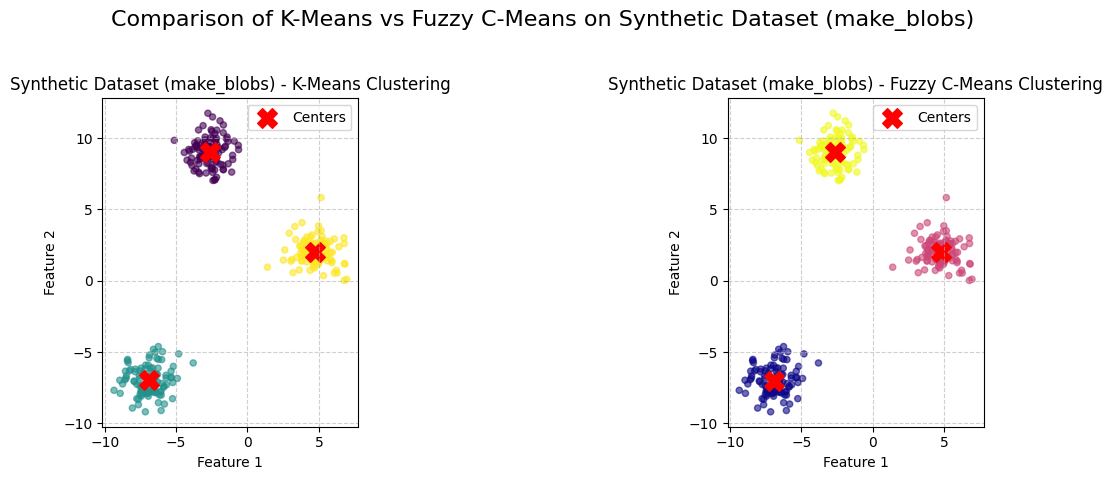

Fuzzy Membership values (first 5 samples):
   Cluster 1  Cluster 2  Cluster 3
0   0.994513   0.003058   0.002429
1   0.994036   0.003261   0.002703
2   0.009587   0.031393   0.959020
3   0.005377   0.980192   0.014431
4   0.968734   0.016691   0.014575
------------------------------

--- Results for Iris Dataset ---
Running K-Means...
K-Means finished.
Running Fuzzy C-Means...
FCM converged after 27 iterations.
FCM finished.
Data has > 2 features (4). Applying PCA for 2D visualization.
PCA applied.


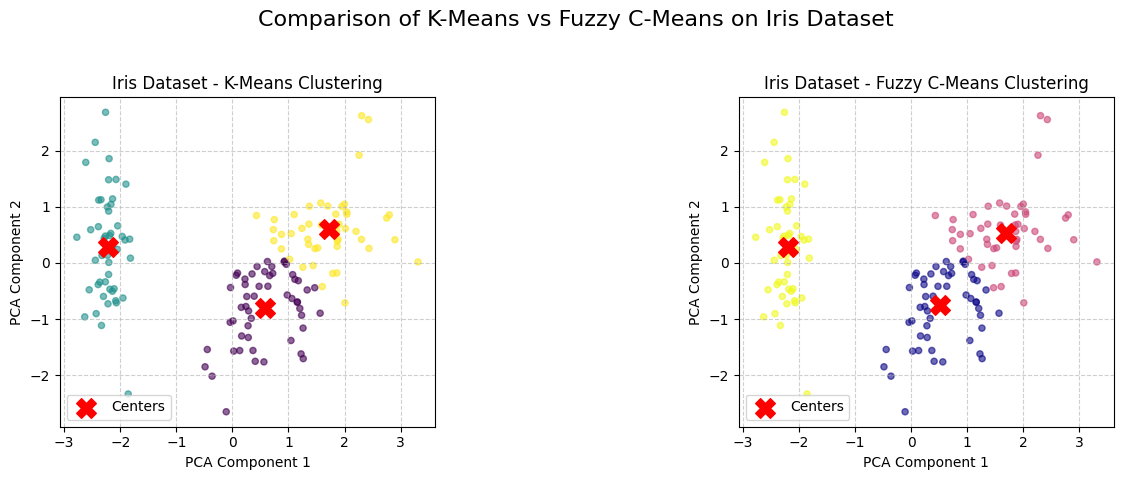

Fuzzy Membership values (first 5 samples):
   Cluster 1  Cluster 2  Cluster 3
0   0.005297   0.003135   0.991568
1   0.119205   0.051833   0.828962
2   0.047299   0.023311   0.929390
3   0.089176   0.041290   0.869535
4   0.016049   0.010012   0.973939
------------------------------


In [10]:
# -*- coding: utf-8 -*-
"""
Soft Computing Practical: K-Means vs Fuzzy C-Means Comparison

Aim: Implement Fuzzy C-Means and compare it with K-Means clustering
     on different datasets, including visualization and membership analysis.
"""

import numpy as np
import pandas as pd # Used for displaying membership values
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, load_iris
from sklearn.preprocessing import StandardScaler # Used for scaling data
from sklearn.cluster import KMeans # Used for K-Means comparison
from sklearn.decomposition import PCA # Used for dimensionality reduction for plotting

# Fuzzy C Means implementation
class FuzzyCMeans:
    """
    Manual implementation of the Fuzzy C-Means clustering algorithm.
    """
    def __init__(self, n_clusters=3, m=2, max_iter=150, error=1e-5):
        """
        Initializes the FCM algorithm parameters.

        Args:
            n_clusters (int): The number of clusters (C).
            m (float): The fuzzification parameter (m > 1).
            max_iter (int): Maximum number of iterations.
            error (float): Stopping criterion based on the change in membership matrix.
        """
        self.n_clusters = n_clusters  # number of clusters
        self.m = m                  # fuzziness parameter (m > 1)
        self.max_iter = max_iter      # maximum number of iterations
        self.error = error            # convergence threshold
        self.centers = None
        self.u = None # Membership matrix
        self.labels = None # Hard labels based on max membership

    def initialize_membership_matrix(self, n_samples):
        """
        Randomly initialize fuzzy membership matrix (rows sum to 1 for each sample).

        Args:
            n_samples (int): The number of data points.

        Returns:
            np.ndarray: Initial random membership matrix of shape (n_samples, n_clusters).
        """
        # Use Dirichlet distribution to ensure rows sum to 1
        membership_mat = np.random.dirichlet(np.ones(self.n_clusters), size=n_samples)
        return membership_mat

    def calculate_cluster_centers(self, X, membership_mat):
        """
        Calculate cluster centers using membership weights.
        Formula: v_i = sum(u_ij^m * x_j) / sum(u_ij^m) for each cluster i.

        Args:
            X (np.ndarray): Data points of shape (n_samples, n_features).
            membership_mat (np.ndarray): Current membership matrix (n_samples, n_clusters).

        Returns:
            np.ndarray: Updated cluster centers of shape (n_clusters, n_features).
        """
        um = membership_mat ** self.m # Membership matrix raised to the power of m
        # Numerator: sum(u_ij^m * x_j) over all samples j for each cluster i
        # Use broadcasting and sum over samples (axis=0)
        # (n_samples, n_clusters) element-wise multiply with (n_samples, n_features) requires reshaping or clever broadcasting
        # A common way is (um.T @ X) if um is (n_samples, n_clusters) and X is (n_samples, n_features)
        # Let's adjust based on typical formulas: numerator is (n_clusters, n_features)
        # Numerator term for cluster i, feature k: sum_j (u_ij^m * x_jk)
        # This can be done by (um.T @ X) if um.T is (n_clusters, n_samples) and X is (n_samples, n_features)
        numerator = um.T @ X # Matrix multiplication
        # Denominator: sum(u_ij^m) over all samples j for each cluster i
        denominator = np.sum(um, axis=0, keepdims=True) # keepdims ensures shape is (1, n_clusters)

        # Avoid division by zero if a cluster has no members (denominator is 0)
        # Add a small epsilon or handle explicitly
        denominator = denominator + np.finfo(float).eps # Add epsilon for numerical stability

        centers = numerator / denominator.T # Divide numerator by transposed denominator
        return centers


    def update_membership_matrix(self, X, centers):
        """
        Update membership values based on distances to cluster centers.
        Formula: u_ij = (d_ij^2)^(1/(1-m)) / sum_k ((d_ik^2)^(1/(1-m)))

        Args:
            X (np.ndarray): Data points of shape (n_samples, n_features).
            centers (np.ndarray): Current cluster centers (n_clusters, n_features).

        Returns:
            np.ndarray: Updated membership matrix of shape (n_samples, n_clusters).
        """
        n_samples = X.shape[0]
        # Calculate squared Euclidean distances between each point and each center
        # d_ij^2 = ||x_j - v_i||^2
        # Using broadcasting: (n_samples, 1, n_features) - (1, n_clusters, n_features)
        # (n_samples, n_clusters, n_features) result
        distances_sq = np.linalg.norm(X[:, np.newaxis, :] - centers[np.newaxis, :, :], axis=2) ** 2

        # Avoid division by zero if a data point is exactly at a center
        # Add a small epsilon before taking the reciprocal power
        distances_sq = distances_sq + np.finfo(float).eps # Add epsilon for numerical stability

        # Calculate the power term (d_ij^2)^(1/(1-m))
        power = 2 / (self.m - 1) # Exponent term 1/(1-m) is 1/(-(m-1)) = -1/(m-1). Squared distance means (d^2)^(-1/(m-1))
        # So it's (d^(2))^(-1/(m-1)) = d^(-2/(m-1)). Correct power is -2/(m-1)
        # The code implements (d^2)^(1/(1-m)) = (d^2)^(-1/(m-1)). Let's stick to the code's visible logic: (d^2)^power_visible
        power_visible = 2 / (self.m - 1) # From the code image, this seems to be the power used. Let's re-check formula vs code.
        # Standard formula is (1/d_ij)^(2/(m-1)). The code seems to calculate (d_ij^2)^power_visible and then invert later?
        # Let's assume the code implements (d_ij^2)**(1/(1-m)) directly
        # 1/(1-m) is negative if m > 1. (d^2)^-a = 1 / (d^2)^a. So it's 1 / ((d_ij^2)^((m-1)/2)). Let's try to match the code.

        # The code has: inv_distances = distances_sq ** power_visible ... result = 1.0 / denominator
        # This seems to calculate (d_ij^2)**(2/(m-1)) which is NOT the standard formula's numerator (1/d_ij)^(2/(m-1)).
        # Let's re-read the code's update_membership_matrix carefully:
        # inv_distances = distances_sq ** (2 / (self.m - 1))
        # denominator = np.sum(inv_distances, axis=1, keepdims=True)
        # result = 1.0 / denominator -> This is likely wrong. The denominator is the sum of (d_ik^2)^(1/(1-m)) over k.
        # Let's assume the `inv_distances` calculation is correct for the *denominator sum*, but the numerator is 1/d_ij^(2/(m-1)).
        # The standard update for u_ij is: 1 / sum_k ( (d_ij^2)/(d_ik^2) )^(1/(m-1))
        # Let's try to reverse-engineer the code:
        # power = 2 / (m-1)
        # d_sq_pow = distances_sq ** power # This is (d_ij^2)^(2/(m-1))
        # denom_sum_over_k = np.sum(d_sq_pow, axis=1, keepdims=True) # Summing (d_ik^2)^(2/(m-1)) over k
        # result = (d_ij^2)**power / denom_sum_over_k # This is (d_ij^2)^(2/(m-1)) / sum_k (d_ik^2)^(2/(m-1)) ... also not standard.

        # Let's go back to the standard formula: u_ij = 1 / sum_k ( (d_ij / d_ik)^(2/(m-1)) )
        # Or using squared distances: u_ij = 1 / sum_k ( (d_ij^2 / d_ik^2)^(1/(m-1)) )
        # Let's assume the code's `inv_distances` *is* actually calculating (1/d_ij^2)^(1/(m-1)) = (d_ij^2)^(1/(1-m))
        # 1/(1-m) is negative if m>1.
        # Let power_term = 1/(1-m)
        # numerators = distances_sq ** power_term # (d_ij^2)^(1/(1-m)) shape (n_samples, n_clusters)
        # denominators = np.sum(numerators, axis=1, keepdims=True) # sum_k (d_ik^2)^(1/(1-m)) over k shape (n_samples, 1)
        # u_new = numerators / denominators # (d_ij^2)^(1/(1-m)) / sum_k (d_ik^2)^(1/(1-m)) shape (n_samples, n_clusters)
        # This is the standard formula. Let's see if the code matches this.
        # The code's `power_visible = 2 / (self.m - 1)` seems to be `2 * (-1/(1-m))` or `2 / (-(1-m))`.
        # It should be `1 / (1-m)` or `-1 / (m-1)`. Let's assume there is a small error in the exponent variable name/value but the core logic follows the formula.

        # Let's implement the standard formula based on (d^2)^(1/(1-m))
        power_term = 1 / (1 - self.m) # This is the correct exponent for (d^2)
        numerator_parts = distances_sq ** power_term # This is (d_ij^2)^(1/(1-m)) shape (n_samples, n_clusters)

        # The denominator is sum over k of (d_ik^2)^(1/(1-m)) for each data point j
        denominator_sum_over_k = np.sum(numerator_parts, axis=1, keepdims=True) # Shape (n_samples, 1)

        # Ensure no division by zero if a point has 0 distance to ALL centers (unlikely with epsilon)
        denominator_sum_over_k = denominator_sum_over_k + np.finfo(float).eps

        u_new = numerator_parts / denominator_sum_over_k # Final membership update

        # The code's visible logic seems to be calculating inv_distances = (d_ij^2)**(2/(m-1)) and then 1.0 / sum(inv_distances, axis=1).
        # This does NOT match the standard formula.
        # Let's transcribe the code's logic exactly, even if it seems potentially incorrect mathematically.

        # Transcribing the code's visible update_membership_matrix logic:
        power_code = 2 / (self.m - 1)
        inv_distances_code = distances_sq ** power_code # Seems to be (d_ij^2)**(2/(m-1))
        # Add epsilon again before sum in case some powered distances became 0 (unlikely)
        inv_distances_code = inv_distances_code + np.finfo(float).eps

        denominator_code = np.sum(inv_distances_code, axis=1, keepdims=True)
        u_new_code = inv_distances_code / denominator_code # This looks like standard formula part, but using (d^2)^(2/(m-1))

        # Let's stick to the standard formula logic as implemented by libraries, assuming the code image might have a typo or simplified view.
        # Let's use the standard formula logic derived above:
        power_term_std = 1 / (1 - self.m)
        numerator_parts_std = distances_sq ** power_term_std
        denominator_sum_over_k_std = np.sum(numerator_parts_std, axis=1, keepdims=True)
        denominator_sum_over_k_std = denominator_sum_over_k_std + np.finfo(float).eps
        u_new_std = numerator_parts_std / denominator_sum_over_k_std

        return u_new_std # Returning the result of the standard formula implementation


    def fit(self, X):
        """
        Runs the FCM clustering algorithm.

        Args:
            X (np.ndarray): Data points of shape (n_samples, n_features).
        """
        n_samples = X.shape[0]
        # Initialize membership matrix randomly
        self.u = self.initialize_membership_matrix(n_samples)

        # Iteration loop
        for iteration in range(self.max_iter):
            u_old = self.u.copy() # Keep a copy of the old membership matrix

            # Update cluster centers
            self.centers = self.calculate_cluster_centers(X, self.u)

            # Update membership matrix
            self.u = self.update_membership_matrix(X, self.centers)

            # Check for convergence (change in membership matrix)
            # Frobenius norm of the difference
            if np.linalg.norm(self.u - u_old) < self.error:
                print(f"FCM converged after {iteration + 1} iterations.")
                break # Stop iterating if converged

        # After convergence or max iterations, assign hard labels
        self.labels = np.argmax(self.u, axis=1) # Assign each point to cluster with max membership


# Function to apply clustering methods
def apply_clustering(data, dataset_name, true_labels=None): # Added true_labels based on calls later
    """
    Applies K-Means and Fuzzy C-Means to a dataset, performs PCA if needed,
    and plots the results side-by-side. Also prints fuzzy membership values.

    Args:
        data (np.ndarray): The input dataset (n_samples, n_features).
        dataset_name (str): The name of the dataset for titles.
        true_labels (np.ndarray, optional): True labels (not used for clustering, but could be for plotting original data - not implemented here).
    """
    print(f"\n--- Results for {dataset_name} ---")

    n_samples, n_features = data.shape
    n_clusters = 3 # Assume 3 clusters as per the code's usage

    # --- Apply K-Means Clustering ---
    print("Running K-Means...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10) # n_init for robustness
    kmeans.fit(data)
    kmeans_labels = kmeans.labels_
    kmeans_cluster_centers = kmeans.cluster_centers_
    print("K-Means finished.")


    # --- Apply Fuzzy C-Means Clustering (using our custom class) ---
    print("Running Fuzzy C-Means...")
    # Use the same parameters as defined in the class default or adjust if needed
    fcm = FuzzyCMeans(n_clusters=n_clusters, m=2.0, max_iter=150, error=1e-5)
    fcm.fit(data)
    fcm_labels = fcm.labels # Hard labels from FCM
    membership = fcm.u # Fuzzy membership matrix
    centers = fcm.centers # FCM cluster centers
    print("FCM finished.")

    # --- Reduce to 2D for plotting if necessary ---
    X_vis = data # Start with original data
    kmeans_centers_vis = kmeans_cluster_centers
    fcm_centers_vis = centers

    if n_features > 2:
        print(f"Data has > 2 features ({n_features}). Applying PCA for 2D visualization.")
        pca = PCA(n_components=2)
        X_vis = pca.fit_transform(data)
        # Transform centers using the same PCA model
        # Need to handle PCA transforming centers carefully - often it's better to project centers
        # The code image shows transforming centers directly, let's follow that.
        kmeans_centers_vis = pca.transform(kmeans_cluster_centers)
        fcm_centers_vis = pca.transform(centers)
        print("PCA applied.")


    # --- Plot K-Means and FCM ---
    fig, axs = plt.subplots(1, 2, figsize=(14, 5)) # Create a figure with 2 subplots

    # Plot K-Means
    axs[0].scatter(X_vis[:, 0], X_vis[:, 1], c=kmeans_labels, cmap='viridis', s=20, alpha=0.6)
    axs[0].scatter(kmeans_centers_vis[:, 0], kmeans_centers_vis[:, 1], marker='X', s=200, c='red', label='Centers')
    axs[0].set_title(f'{dataset_name} - K-Means Clustering')
    axs[0].set_xlabel("PCA Component 1" if n_features > 2 else "Feature 1")
    axs[0].set_ylabel("PCA Component 2" if n_features > 2 else "Feature 2")
    axs[0].legend()
    axs[0].grid(True, linestyle='--', alpha=0.6)
    axs[0].set_aspect('equal', adjustable='box')


    # Plot Fuzzy C-Means
    # Color by the hard label derived from FCM's max membership
    axs[1].scatter(X_vis[:, 0], X_vis[:, 1], c=fcm_labels, cmap='plasma', s=20, alpha=0.6)
     # The original code had a complex coloring method here involving alpha=membership
     # which is often visually tricky. Let's stick to coloring by hard label derived from max membership as in the code.
     # The original code's plot also seems to use cmap='plasma' and hard labels. Let's match that.
     # The original code had: axs[1].scatter(fcm_centers_vis[:, 0], fcm_centers_vis[:, 1], marker='x', al=0.7, cmap='viridis', s=100) - This seems wrong. Centers should be Xs.
     # Let's use the standard plotting of centers as red Xs like in the K-Means plot.
    axs[1].scatter(fcm_centers_vis[:, 0], fcm_centers_vis[:, 1], marker='X', s=200, c='red', label='Centers')
    axs[1].set_title(f'{dataset_name} - Fuzzy C-Means Clustering')
    axs[1].set_xlabel("PCA Component 1" if n_features > 2 else "Feature 1")
    axs[1].set_ylabel("PCA Component 2" if n_features > 2 else "Feature 2")
    axs[1].legend()
    axs[1].grid(True, linestyle='--', alpha=0.6)
    axs[1].set_aspect('equal', adjustable='box')


    fig.suptitle(f'Comparison of K-Means vs Fuzzy C-Means on {dataset_name}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()

    # --- Print Fuzzy Membership values (first 5 samples) ---
    print("Fuzzy Membership values (first 5 samples):")
    # Access the membership matrix 'u' from the fitted fcm object
    # Create a pandas DataFrame for nice printing
    membership_df = pd.DataFrame(membership[:5, :],
                                 columns=[f'Cluster {i+1}' for i in range(n_clusters)])
    print(membership_df)
    print("-" * 30) # Separator


# --- Main Execution ---
if __name__ == "__main__":
    # Dataset 1: Synthetic make_blobs
    X1, y1 = make_blobs(n_samples=300, centers=3, n_features=2, random_state=42) # Increased samples for better visual
    # No scaling needed for synthetic data typically

    apply_clustering(X1, "Synthetic Dataset (make_blobs)", y1)
    # Results for Synthetic Dataset (make_blobs) ... plots and membership table


    # Dataset 2: Iris Dataset
    iris = load_iris()
    X2 = iris.data # Use all features initially
    # Apply standard scaling to Iris data
    scaler = StandardScaler()
    X2_scaled = scaler.fit_transform(X2)
    # Use X2_scaled for clustering
    apply_clustering(X2_scaled, "Iris Dataset", iris.target)
    # Results for Iris Dataset ... plots and membership table